We'll want to save all these new images and labels to a folder. Not sure what's the best structure... Probably take a look at keras to see what's expected for the image tensor...
Also we'll also want to resize the image so that they all have the same size that is compatible with and probably convert everything to greyscale.
Great resources available at: https://developers.google.com/machine-learning/practica/image-classification
Take a look at the colab for snippets of code and useful functions in keras/tensorflow framework
Note that the data augmentation can be done as part of the preprocessing pipeline directly. So let's just split images manually and otherwise use the built-in functionalities to manipulate the images.

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.io

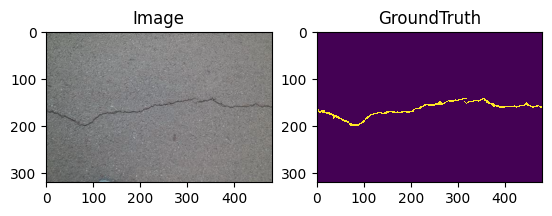

In [3]:
def load_image_and_gnd_truth(image_name):
    ''' Load image and corresponding label from their respective folders, convert the image to greyscale '''
    data_path='/home/coline/Documents/opencv_project/CrackForest-dataset/CrackForest-dataset-master'
    img = cv.imread(data_path+'/image/'+image_name+'.jpg')
    matfile=scipy.io.loadmat(data_path+'/groundTruth/'+image_name+'.mat')
    return img, matfile['groundTruth'][0][0][0]
# Test
image, ground_truth = load_image_and_gnd_truth('001')
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(ground_truth, interpolation='none')
ax[1].set_title('GroundTruth')
plt.show()

In [4]:
PIX_CRACK_THRESH=20
def get_label(ground_truth):
    '''Is there a crack in the image according to the ground truth data? '''
    n=(ground_truth-np.ones_like(ground_truth)).sum()
    # If there are not a lot of pixels showing the crack in the image it's impossible to see it
    if n>=PIX_CRACK_THRESH:
        label='crack'
    else:
        label='no_crack'
    return label

# Test
img, gnd_truth = load_image_and_gnd_truth('002')
test1=get_label(gnd_truth)
artificial_gnd_truth= np.ones((32,32))
test2=get_label(artificial_gnd_truth)
if test1=='crack' and test2=='no_crack':
    print('success')
else:
    print('fail')

success


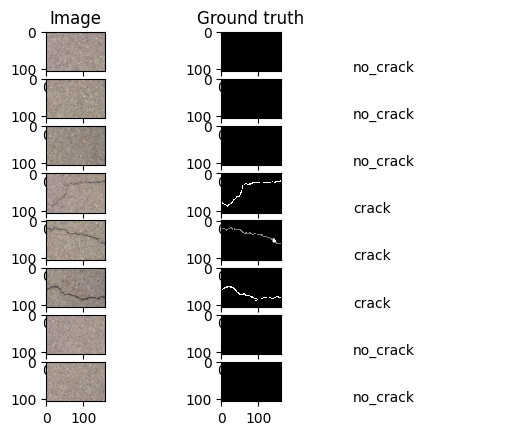

In [5]:
def split(k,img):
    '''Split the image in 2^k equally accross the first 2 dimensions
    /!\ The resulting images are views (shallow copy) of the image
    '''
    n,m =img.shape[0:2]
    height=n//k
    width=m//k
    splitted=[]
    for i in range(0,k):
        for j in range(0,k):
            splitted.append(img[i*height:(i+1)*height,j*width:(j+1)*width,...])
    return splitted

# Test
img, gnd_truth = load_image_and_gnd_truth('114')
n=3
splitted_imgs = split(n,img)
splitted_gnd_truth = split(n,gnd_truth)

fig, ax = plt.subplots(2**n,3)
for i in range(0, 2**n):
    ax[i,0].imshow(splitted_imgs[i])
    ax[i,1].imshow(splitted_gnd_truth[i], interpolation='none',cmap='gray')
    label=get_label(splitted_gnd_truth[i])
    ax[i,2].text(0,0,label)
    ax[i,2].set_axis_off()
ax[0,0].set_title('Image')
ax[0,1].set_title('Ground truth')
plt.show()

generate the data
1. Create folders to hold it
CrackBinaryClassificationData
  * train
    * crack
    * no_crack
  * test
    * crack
    * no_crack
2. Fill the folders
Split between training and validation (validation data available for image 001 to 118)
Iterate over each set
Save results to corresponding folder

In [41]:
import random
train_test_ratio=0.8
k=int(118*train_test_ratio)
shuffled=[i for i in range(1,119)]
random.shuffle(shuffled)
root='CrackBinaryClassificationData/'
for index in range(0,len(shuffled)):
    i=shuffled[index]
    if index<=k:
        subfolder='train/'
    else:
        subfolder='test/'
    image, ground_truth = load_image_and_gnd_truth(f'{i:03d}')
    splitted_images=split(3,image)
    splitted_gnd_truth=split(3,ground_truth)
    splitted_images.append(image)
    splitted_gnd_truth.append(ground_truth)
    for j in range(0,len(splitted_images)):
        label=get_label(splitted_gnd_truth[j])
        path=root+subfolder+label
        success=cv.imwrite(path+f'/{i}_{j}.jpg',splitted_images[j])
        if not success:
            raise IOError(f'Failed to save image at {path}/{i}_{j}.jpg')

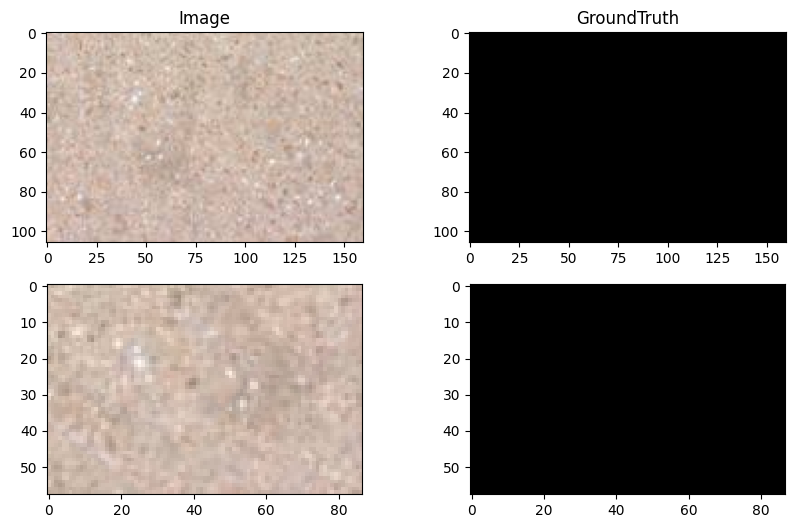

In [13]:
import math
from scipy import ndimage
import matplotlib.pyplot as plt

def rotate(theta_deg,img):
    # Rotating the image and keeping a zoomed in version of the image that only contains original pixels and has the same aspect ratio as the original image
    # Math derived by hand
    full_img_rot = ndimage.rotate(img, theta_deg, reshape=True)
    h,l=img.shape[0:2]
    alpha=math.atan2(h,l)
    theta=math.radians(theta_deg)
    d_prime=h/math.sin(theta+alpha)
    h_prime=d_prime*math.sin(alpha)
    l_prime=d_prime*math.cos(alpha)
    x_min = h_prime*math.sin(theta)
    x_max = l-l_prime*math.cos(theta)
    p0=l*math.sin(theta)
    p1_y=p0-x_min*math.sin(theta)
    p1_x=x_min*math.cos(theta)
    p2_y=p1_y+h_prime
    p2_x=p1_x+l_prime
    return full_img_rot[math.ceil(p1_y):int(p2_y),math.ceil(p1_x):int(p2_x)]

angle=55
img, ground_truth = load_image_and_gnd_truth('106')
n=3
splitted_imgs = split(n,img)
splitted_gnd_truth = split(n,ground_truth)
base_img=splitted_imgs[7]
gnd_truth=splitted_gnd_truth[7]
rotated_img=rotate(angle,base_img)
rotated_gndTruth = rotate(angle,gnd_truth)

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots(2, 2)
ax[0,0].imshow(base_img)
ax[0,0].set_title('Image')
ax[0,1].imshow(gnd_truth, interpolation='none', cmap='gray')
ax[0,1].set_title('GroundTruth')
ax[1,0].imshow(rotated_img)
ax[1,1].imshow(rotated_gndTruth, interpolation='none', cmap='gray')
plt.show()

In [18]:
# Should have set a seed
# Get the name of all images in train set
import os
root='CrackBinaryClassificationData/'
subfolder='train/'
label='crack'
crack_file=os.listdir(root+subfolder+label)
filename_set=set()
for f in crack_file:
    filename_set.add(int(f.split('_')[0]))

In [17]:
# Fix mistakes
import os
root='CrackBinaryClassificationData/'
subfolder='train/'
label='crack/'
files_to_delete = []
for f in os.listdir(root+subfolder+label):
    if 'rot' in f:
        files_to_delete.append(f)

for f in files_to_delete:
    os.remove(root+subfolder+label+f)

In [19]:
# Add some more data to the training set by rotating the image by a random angle
# The rotation might remove the crack so validate the label using the ground truth
from numpy.random import default_rng
rng = default_rng(seed=42)
n=len(filename_set)
angles = rng.integers(10, 80, size=(n)) # angle between [10 and 80]
root='CrackBinaryClassificationData/'
subfolder='train/'
for index, val in enumerate(filename_set):
    base_img, gnd_truth = load_image_and_gnd_truth(f'{val:03d}')
    a=angles[index]
    rotated_img=rotate(a,base_img)
    rotated_gndTruth = rotate(a,gnd_truth)
    label=get_label(rotated_gndTruth)
    path=root+subfolder+label
    success=cv.imwrite(path+f'/{val}_rot_{a}.jpg',rotated_img)
    if not success:
        raise IOError(f'Failed to save image at {path}/{val}_rot_{a}.jpg')

# We also would like the class to be balanced so could do a little oversampling of the no crack set

In [21]:
# Get the number of samples to add to each
# Path to data folders
root='CrackBinaryClassificationData/'
train_dir = root+'train/'
test_dir = root+'test/'

train_crack_dir = train_dir+'crack/'
train_nocrack_dir = train_dir+'no_crack/'

test_crack_dir = test_dir+'crack/'
test_nocrack_dir = test_dir+'no_crack/'

crack_dir=train_crack_dir
nocrack_dir=train_nocrack_dir
# Note: I've looked at the sizes and I know the nocrack folder is smaller for both train and test, so no need to check which folder to oversample
# The folder is smaller by a factor less than 2
# No error catching below in case n_to_add is bigger than n_nocrack (shuffle would not work)
from numpy.random import default_rng
rng = default_rng(seed=31)
n_crack=len(os.listdir(crack_dir))
n_nocrack=len(os.listdir(nocrack_dir))
n_to_add=n_crack-n_nocrack
angles = rng.integers(10, 80, size=(n_to_add)) # angle between [10 and 80]
nocrack_files=os.listdir(nocrack_dir)
rng.shuffle(nocrack_files)
for i in range(0, n_to_add):
    f=nocrack_files[i]
    f_name=f.split('.')[0]
    img = cv.imread(nocrack_dir+f)
    a=angles[i]
    rotated_img=rotate(a,img)
    success=cv.imwrite(nocrack_dir+f'{f_name}_rot_{a}.jpg',rotated_img)
    if not success:
        raise IOError(f'Failed to save image at {nocrack_dir}{f_name}_rot_{a}.jpg')
    
